# Introduction

In the following notebook, we want to investigate how we can use machine learning models to evaluate customer sentiment based on a review. The data that we look at here in the __yelp review__ data which has 1-5 star ratings for restaurants.

## Conclusions
I found that 1-5 star rating were not particularly helpful because the 2,3,4 star reviews could not be predicted very accurately. It was better to have only two outcomes, 0 (bad) or 1 (positive) which yielded better results. The final accuracy was around ~75%.


In [1]:
# Read in the Yelp review data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Read in the Yelp review data
yelp = pd.read_csv('yelp.csv')

# Show the first few columns of the data
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


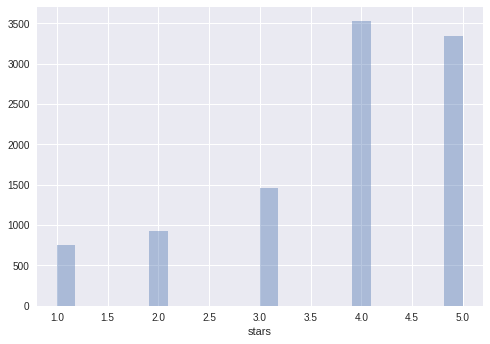

In [2]:
# Show the distribution of the Review data

sns.distplot(yelp["stars"], kde=False, rug=False)
plt.show()

** Note, from the above plot, the data set is biased towards 4 and 5 star reviews. This may introduce some bias into the model, so we will balance the data.**

In [3]:
# This cell will balance the data for the model

# let us first randomize the yelp data
yelp = yelp.sample(frac=1)

df_1_star = yelp[yelp["stars"]== 1]

# The number of one star reviews
num_1_star=df_1_star.count()[0]

# now we choose the first N reviews of a certain star number
df_2_star = yelp[yelp["stars"]== 2].head(num_1_star)
df_3_star = yelp[yelp["stars"]== 3].head(num_1_star)
df_4_star = yelp[yelp["stars"]== 4].head(num_1_star)
df_5_star = yelp[yelp["stars"]== 5].head(num_1_star)

# Now we combine all of the data frames
frames = [df_1_star,df_2_star,df_3_star,df_4_star,df_5_star]

yelp_balanced = pd.concat(frames)

# Shuffle the data frame to randomize everything
yelp_balanced = yelp_balanced.sample(frac=1)
yelp_balanced.index = range(0,yelp_balanced.shape[0]) # Relabel the indices
yelp_balanced.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,5oIiBxbTYuWAtHx7-alXbA,2009-04-26,O2szBGfOjIx0Gxqft0tk3g,1,Needs a new name - now. \n\nThe Pischke's of ...,review,vNFxfUDTPgZRgV3EHnkmJg,0,2,0
1,V1nEpIRmEa1768oj_tuxeQ,2008-11-08,BW4EXlUnFF21xbDCgb_REQ,3,"Cibo is a really adorable place, but I can't s...",review,0lxf4v5NuJ1U6Bk7SGAJ5w,5,7,2
2,TqHTtjPANCBKGsjGBjDoQQ,2009-05-24,vus5QnNLxuB7mqG6iqBFqg,4,My daughter and I sort of stumbled on this pla...,review,ZmIgP4U4Ht9CYmNX0_zP6w,13,12,8
3,d3MxUXS1b6U2P_gGuCO1-A,2009-09-24,KEQh_cm_yvdFQYFpNFcNPw,4,I came here with three other friends. We were...,review,QfnKAXo0aOk0AFPPRa-WIw,0,0,0
4,zOCdVUKUN3b-obT67Qjyww,2012-06-12,DhCil3hVnLpP19AyhFYEFQ,4,Given the dearth of German restaurants in the ...,review,8T0evnkvRaTomru7ghPGeg,1,4,0


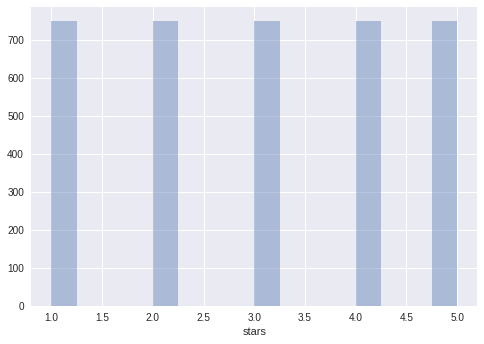

In [4]:
# Show the distribution of the Balanced Review data

sns.distplot(yelp_balanced["stars"], kde=False, rug=False)
plt.show()



Now we see that the dataset is balanced. This should help eliminate the bias of our training algorithms.

In [5]:
# Now we need to process the text. We define here a function that will remove the punctuation and stopwords

import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

# In case we dont have the nltk stopwords documents
nltk.download("stopwords")

@np.vectorize
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    words = filter(lambda x: x not in stopwords.words('english'), tokens)
    #words = [char for char in text if char not in string.punctuation]
    return " ".join(words)

print("Total number of data: ",yelp_balanced.shape[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sovereign/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Total number of data:  3745


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

# Let us now generate a subset of the data to create a vocabulary with
n_sample = 3000
n_features = 1000 # Number of features to use for constructing the dictionary
dict_sample = []

# Now we preprocess the entire balanced data set
# yelp_balanced.shape[0]
for i in tqdm(range(0,n_sample)):
    sentence = yelp_balanced["text"][i]
    dict_sample.append(preprocess(sentence))

    # Convert to numpy array
dict_sample = np.asarray(dict_sample)


# Instantiate the object
count_vec = CountVectorizer(max_features=n_features)

# Bag of word model
bow = count_vec.fit(dict_sample)


print("The size of the vocabulary is: ", len(bow.vocabulary_))

100%|██████████| 3000/3000 [04:17<00:00, 11.64it/s]


The size of the vocabulary is:  1000


In [8]:
from sklearn.model_selection import train_test_split

# Now we must transform our original review data into a feature Matrix

X = []
y = []

# converting the data frame into a feature matrix
for i in range(0,yelp_balanced.shape[0]):
    X.append(yelp_balanced['text'][i])
    y.append(yelp_balanced['stars'][i])

X = np.asarray(X)
y = np.asarray(y)

X = bow.transform(X)

# Now we split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=101)



In [9]:
# We compare the results of different classifiers, relative to the basiline model (random guessing) for reference


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from numpy.random import randint

# Now we train different models
nb = MultinomialNB()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(max_depth=2, random_state=0)
lr = LogisticRegression(multi_class='multinomial',solver='newton-cg')


nb.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)


preds_bl = randint(1,6,len(y_test))
preds_nb = nb.predict(X_test)
preds_dt = dt.predict(X_test)
preds_rf = rf.predict(X_test)
preds_lr = lr.predict(X_test)

print('================================================================\n')
print("Baseline Model: \n",classification_report(y_test,preds_bl))
print('================================================================\n')
print("Naive Bayes: \n" ,classification_report(y_test,preds_nb))
print('================================================================\n')
print("Desicion Tree: \n",classification_report(y_test,preds_dt))
print('================================================================\n')
print("Random Forests: \n",classification_report(y_test,preds_rf))
print('================================================================\n')
print("Logistic Regression: \n",classification_report(y_test,preds_lr))
print('================================================================\n')


Baseline Model: 
              precision    recall  f1-score   support

          1       0.20      0.20      0.20       740
          2       0.19      0.20      0.19       744
          3       0.19      0.17      0.18       739
          4       0.21      0.21      0.21       739
          5       0.21      0.21      0.21       746

avg / total       0.20      0.20      0.20      3708


Naive Bayes: 
              precision    recall  f1-score   support

          1       0.46      0.35      0.40       740
          2       0.22      0.13      0.16       744
          3       0.23      0.52      0.32       739
          4       0.24      0.31      0.27       739
          5       0.14      0.02      0.03       746

avg / total       0.26      0.27      0.24      3708


Desicion Tree: 
              precision    recall  f1-score   support

          1       0.23      0.23      0.23       740
          2       0.29      0.18      0.22       744
          3       0.18      0.23      0

# Comments:

* From these results, it seems that the best classifier is the __multinomial naive bayes__, this is the classifier that we will use for the subsequent investigation. 
* It seems that 2-3 star reviews are fairly indistinguishable since the multiclass classifier obtains precision scores similar to the baseline model. Therefore, we should just use two outcomes, positive or negative (1 or 0, respectively).

In [10]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# Now we must transform our original review data into a feature Matrix with two outputs (0,1)

X_bin = []
y_bin = []

# Maps (1,2) -> 0, (4,5) -> 1, and 3 -> random number (0,1)
def mapping(x):
    
    if(x==1):
        s = 0
    elif(x==2):
        s = 0
    elif(x==3):
        s = randint(0,2)
    elif(x==4):
        s = 1
    elif(x==5):
        s =1
    else:
        s=x
    
    return s


# converting the data frame into a feature matrix, using the mapping function above.
for i in range(0,yelp_balanced.shape[0]):
    X_bin.append(yelp_balanced['text'][i])
    y_bin.append(mapping(yelp_balanced['stars'][i]))

X_bin = np.asarray(X_bin)
y_bin = np.asarray(y_bin)

X_bin = bow.transform(X_bin)

# Now we split the data into a training and test set
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.2)


# Now we train different models
nb_bin = MultinomialNB()


nb_bin.fit(X_bin_train, y_bin_train)

# Make predictions using the model we trained
preds_bl_bin = randint(0,2,len(y_bin_test))
preds_nb_bin = nb_bin.predict(X_bin_test)

print('================================================================\n')
print("Baseline Model: \n",classification_report(y_bin_test,preds_bl_bin))
print('================================================================\n')
print("Naive Bayes: \n" ,classification_report(y_bin_test,preds_nb_bin))
print('================================================================\n')

/home/sovereign/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Baseline Model: 
              precision    recall  f1-score   support

          0       0.49      0.52      0.50       358
          1       0.53      0.50      0.52       391

avg / total       0.51      0.51      0.51       749


Naive Bayes: 
              precision    recall  f1-score   support

          0       0.79      0.77      0.78       358
          1       0.80      0.81      0.80       391

avg / total       0.79      0.79      0.79       749




In [11]:
# Lets construct a validation set to test overfitting

X_bin_data, X_bin_validation, y_bin_data, y_bin_validation = train_test_split(X_bin, y_bin, test_size=0.2)

print('================================================================')
print("Our Model buliding set size is: ", X_bin_data.shape[0])
print("Our Model validation set size is: ",X_bin_validation.shape[0])
print('================================================================\n')

Our Model buliding set size is:  2996
Our Model validation set size is:  749



In [12]:
# Now we implement our own cross validation function
# This was needed because the built in SCIKIT LEARN function did not yield correct results.

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def KFold_CV(X,y,n):
    
    accuracies = np.zeros(n)
    
    kfold = KFold(n, shuffle=True)
    c = 0
    
    for train, test in kfold.split(y):
        #print('train: %s, test: %s' % (X[train], X[test]))
        X_train = X[train]
        X_test = X[test]
        
        y_train = y[train]
        y_test = y[test]
        
        # Fit the model using the training data
        nb = MultinomialNB()
        nb.fit(X_train,y_train)
        
        # Make a prediction using the test data
        preds_nb = nb_bin.predict(X_test)
        
        # Test the accuracy of the model
        acc = accuracy_score(y_test,preds_nb)
        
        accuracies[c]=acc
        
        # Increment index
        c+=1
    
    average = np.mean(accuracies)
    stdev = np.std(accuracies)
        
    
    return average,stdev

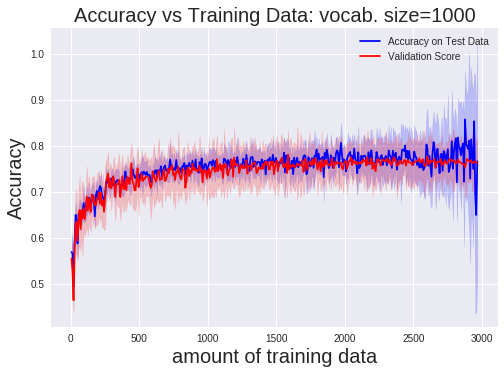

In [14]:
# Let us examine to see of we have any indication of overfitting
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

N= []
sc = []
unc = []

sc_val = []
unc_val = []

for p in np.linspace(0.01,1.0,400,endpoint=False):
    
    # Now we split the subset data into a training and test set
    X_bin_train2, X_bin_test2, y_bin_train2, y_bin_test2 = train_test_split(X_bin_data, y_bin_data, test_size=p)

    # Now we train Multinomial Bayes eacg time
    nb_bin = MultinomialNB()
    nb_bin.fit(X_bin_train2, y_bin_train2)
    
    # Use K-fold cross validation to calculate accuracy and stdev using the test data set
    acc,std = KFold_CV(X_bin_test2,y_bin_test2,n=10)
    
    # Use K-fold cross validation to calculate accuracy and stdev using the validation set
    acc_val,std_val = KFold_CV(X_bin_validation,y_bin_validation,n=10)
    
    N.append(int((1.0-p)*y_bin_data.shape[0]))
    sc.append(acc)
    unc.append(std)
    sc_val.append(acc_val)
    unc_val.append(std_val)
 
# Convert everything to numpy arrays
N= np.asarray(N)
sc = np.asarray(sc)
unc = np.asarray(unc)
unc_val = np.asarray(unc_val)


# Now we plot the Accuracy of the model vs the amount of training data
plt.clf()
plt.title("Accuracy vs Training Data: vocab. size="+str(n_features),size=20)
plt.plot(N,sc,c="b",label="Accuracy on Test Data")
plt.fill_between(N, sc-unc, sc+unc,alpha=0.2, color="b")
plt.fill_between(N, sc_val-unc_val, sc_val+unc_val,alpha=0.2, color="r")
plt.plot(N, sc_val,c="r",label="Validation Score")
plt.xlabel("amount of training data",size=20)
plt.ylabel("Accuracy",size=20)
plt.legend()
plt.show()

# Observations

* The model accuracy appears to converge very slowly as we increase the data size.
* Overfitting is appearant as the training data increases to the whole set. 
* A good score is achieved at ~1500 training samples.